In [ ]:
import os
import librosa
import numpy as np

# --- Config ---
SR = 16000
N_MELS = 64
DURATION = 3  # seconds
SAMPLES = SR * DURATION
CLASS_MAP = {"real": 0, "fake": 1}

# --- 1. Feature Extraction ---
def extract_log_mel(path):
    # Load audio file with specified sample rate
    y, _ = librosa.load(path, sr=SR, mono=True)
    
    # Ensure consistent length
    y = librosa.util.fix_length(y, size=SAMPLES)
    
    # Calculate mel spectrogram - fixed by passing y as a named parameter
    mel_spec = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=N_MELS)
    
    # Convert to log scale (dB)
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel

# --- 2. Load Dataset into Arrays ---
def load_dataset(split_dir):
    X, y = [], []
    for label in CLASS_MAP:
        class_dir = os.path.join(split_dir, label)
        if not os.path.exists(class_dir):
            continue
        files = [f for f in os.listdir(class_dir) if f.endswith(".wav")]
        for fname in files:
            fpath = os.path.join(class_dir, fname)
            try:
                log_mel = extract_log_mel(fpath)
                X.append(log_mel)
                y.append(CLASS_MAP[label])
            except:
                continue

    X = np.array(X)
    y = np.array(y)

    # Do NOT normalize here
    X = X[..., np.newaxis]
    return X, y

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import librosa
import librosa.display


/Users/madhavgalhotra/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [10]:
# ==== STEP 1: Reshape Data ====
def reshape_data(X):
    """
    Reshape input data from (batch, time, freq, channels) → (batch, time, features)
    Assumes channel dimension is last and equal to 1
    """
    if X.ndim == 4 and X.shape[-1] == 1:
        return X.squeeze(-1)  # (batch, time, freq)
    elif X.ndim == 3:
        return X  # already correct
    else:
        raise ValueError(f"Unexpected input shape: {X.shape}")


In [11]:

# ==== STEP 2: Build Model ====
def build_bilstm_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Dropout(0.3),

        layers.Bidirectional(layers.LSTM(64)),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model


In [12]:

# ==== STEP 3: Train Model ====
def train_model(X_train, y_train, X_val, y_val, model_path="BiLSTM.keras"):
    input_shape = X_train.shape[1:]

    model = build_bilstm_model(input_shape)
    model.summary()

    # Callbacks
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        shuffle=True
    )

    # Save best model
    model.save(model_path)

    return model, history



In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model performance on test set"""
    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics
    test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
    
    # Print results
    print("\n===== Model Evaluation =====")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

    return y_pred, y_pred_prob



In [16]:
np.random.seed(42)
tf.random.set_seed(42)

# 1. Load data
base_path = "./data_preprocessed"
    
print("Loading training data...")
X_train, y_train = load_dataset(os.path.join(base_path, "training"))
print(f"Training set: {X_train.shape}, {y_train.shape}, Class distribution: {np.bincount(y_train)}")

print("\nLoading validation data...")
X_val, y_val = load_dataset(os.path.join(base_path, "validation"))
print(f"Validation set: {X_val.shape}, {y_val.shape}, Class distribution: {np.bincount(y_val)}")

print("\nLoading testing data...")
X_test, y_test = load_dataset(os.path.join(base_path, "testing"))
print(f"Testing set: {X_test.shape}, {y_test.shape}, Class distribution: {np.bincount(y_test)}")


# Compute normalization stats from training set only
mean = np.mean(X_train)
std = np.std(X_train)

# Normalize all splits using train stats
X_train = (X_train - mean) / std
X_val   = (X_val - mean) / std
X_test  = (X_test - mean) / std

# Example: reshape your datasets
X_train = reshape_data(X_train)
X_val = reshape_data(X_val)
X_test = reshape_data(X_test)

Loading training data...
Training set: (48509, 64, 94, 1), (48509,), Class distribution: [24223 24286]

Loading validation data...
Validation set: (10394, 64, 94, 1), (10394,), Class distribution: [5190 5204]

Loading testing data...
Testing set: (10397, 64, 94, 1), (10397,), Class distribution: [5192 5205]


In [17]:
# ==== STEP 4: Call Training ====
print("\nTraining the model...")
model, history = train_model(X_train, y_train, X_val, y_val)



Training the model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64, 256)        │       228,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,793 (1.59 MB)

 Trainable params: 417,665 (1.59 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/10
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 257s 167ms/step - accuracy: 0.8451 - auc: 0.9132 - loss: 0.3780 - val_accuracy: 0.9423 - val_auc: 0.9863 - val_loss: 0.1503 - learning_rate: 1.0000e-04
Epoch 2/10
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 272s 179ms/step - accuracy: 0.9345 - auc: 0.9802 - loss: 0.1741 - val_accuracy: 0.9594 - val_auc: 0.9915 - val_loss: 0.1143 - learning_rate: 1.0000e-04
Epoch 3/10
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 294s 194ms/step - accuracy: 0.9532 - auc: 0.9882 - loss: 0.1299 - val_accuracy: 0.9658 - val_auc: 0.9940 - val_loss: 0.0960 - learning_rate: 1.0000e-04
Epoch 4/10
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 264s 174ms/step - accuracy: 0.9628 - auc: 0.9919 - loss: 0.1040 - val_accuracy: 0.9720 - val_auc: 0.9953 - val_loss: 0.0864 - learning_rate: 1.0000e-04
Epoch 5/10
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 271s 179ms/step - accuracy: 0.9713 - auc: 0.9943 - loss: 0.0852 - val_accuracy: 0.9776 - val_auc: 0.9967 - val_loss: 0.0668 - learning_rate: 1.0000e-04
Epoch 6/10
1516/1516 ━━━━━━━━━


Evaluating model...
325/325 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step

===== Model Evaluation =====
Test Accuracy: 0.9883
Test AUC: 0.9980
Test Loss: 0.0387

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      5192
        Fake       0.99      0.99      0.99      5205

    accuracy                           0.99     10397
   macro avg       0.99      0.99      0.99     10397
weighted avg       0.99      0.99      0.99     10397



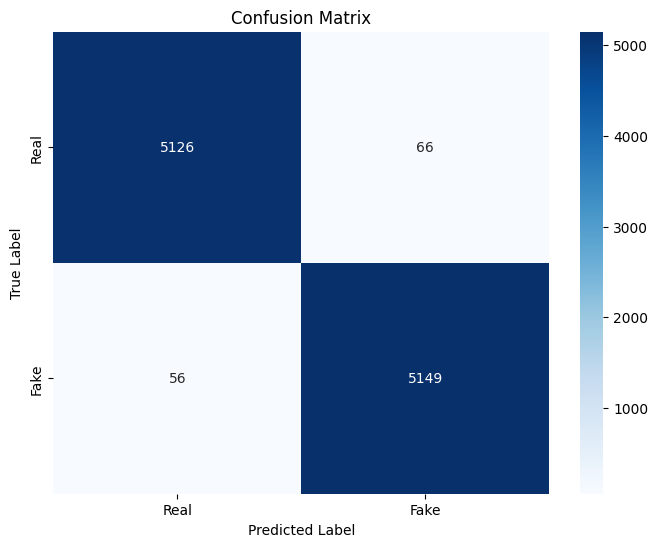

In [37]:

# 3. Evaluate model
print("\nEvaluating model...")
y_pred, y_pred_prob = evaluate_model(model, X_test, y_test)


In [39]:
import matplotlib.pyplot as plt
import numpy as np

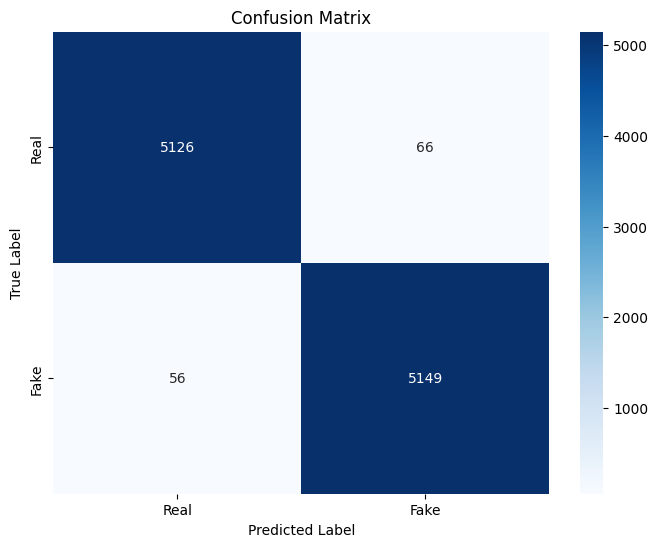

In [40]:
def plot_confusion_matrix(y_true, y_pred, labels):
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Real", "Fake"], 
                yticklabels=["Real", "Fake"])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    plt.savefig('cnn_confusion_matrix.png')
    plt.close()

plot_confusion_matrix(y_test, y_pred, ["Real", "Fake"])


Plotting training history...


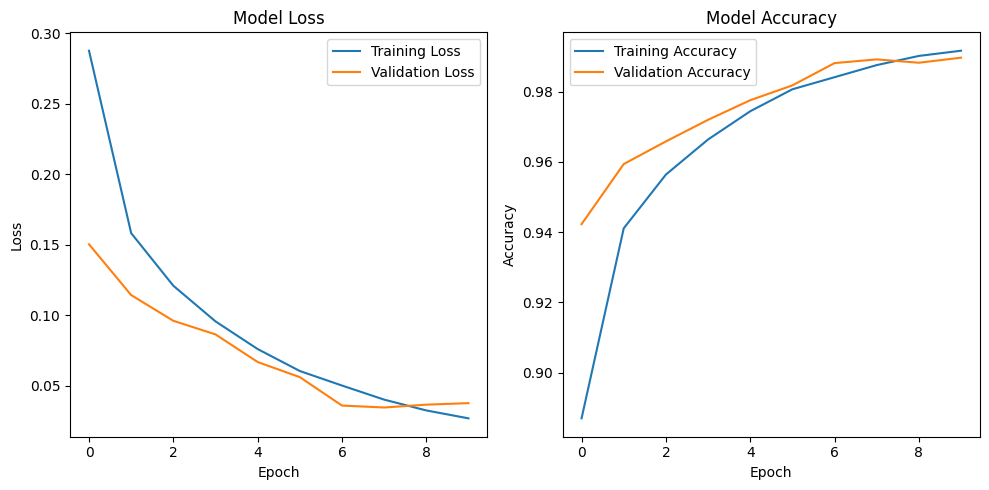

In [41]:
# 1. Plot training history
def plot_training_history(history):
    print("\nPlotting training history...")
    
    # Plot training & validation loss values
    plt.figure(figsize=(10, 5))

    # Plot Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()  # Display the plot
    plt.savefig('BiLSTM_training_history.png')  # Save the plot
    plt.close()  # Close the plot to free memory

# Plot training history
plot_training_history(history)
